In [1]:
import pandas as pd
import numpy as np


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [4]:
import xgboost as xgb
import lightgbm as lgb
import shap


In [5]:
import streamlit as st
import joblib


In [6]:
data = pd.read_csv("loan_data.csv")


In [7]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [8]:
data_dic = pd.read_csv("data_dictionary.csv")

data_dic.head(10)

,Column,Description,Special
0,NaN,NaN,NaN
1,SK_ID_CURR,ID of loan in our sample,NaN
2,TARGET,Target variable (1 - client with payment diffi...,NaN
3,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
4,CODE_GENDER,Gender of the client,NaN
5,FLAG_OWN_CAR,Flag if the client owns a car,NaN
6,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
7,CNT_CHILDREN,Number of children the client has,NaN
8,AMT_INCOME_TOTAL,Income of the client,NaN
9,AMT_CREDIT,Credit amount of the loan,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Columns: 158 entries, SK_ID_CURR to NFLAG_INSURED_ON_APPROVAL
dtypes: float64(80), int64(46), object(32)
memory usage: 1.7+ GB


In [10]:
data.shape

(1413701, 158)

In [11]:
data.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START_x',
 'HOUR_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGIN

In [12]:
d = data.isnull().mean()*100
sorted_df = d.sort_values(ascending=False).reset_index()

sorted_df.columns = ['Column_name', 'missing_percentage']

segment1 = sorted_df.iloc[0:60]
segment2 = sorted_df.iloc[60:120]
segment3 = sorted_df.iloc[120:]

combined_df = pd.DataFrame({
    'Column1': segment1['Column_name'].reset_index(drop=True),
    'NULL % 1 to 60': segment1['missing_percentage'].reset_index(drop=True),
    'Column2': segment2['Column_name'].reset_index(drop=True),
    'NULL % 60 to 120': segment2['missing_percentage'].reset_index(drop=True),
    'Column3': segment3['Column_name'].reset_index(drop=True),
    'NULL % 120+': segment3['missing_percentage'].reset_index(drop=True)
})

combined_df

,Column1,NULL % 1 to 60,Column2,NULL % 60 to 120,Column3,NULL % 120+
0,RATE_INTEREST_PRIMARY,99.661102,OCCUPATION_TYPE,32.367523,FLAG_DOCUMENT_2,0.0
1,RATE_INTEREST_PRIVILEGED,99.661102,AMT_GOODS_PRICE_y,22.602021,FLAG_DOCUMENT_3,0.0
2,COMMONAREA_MODE,69.689347,AMT_ANNUITY_y,21.731469,FLAG_DOCUMENT_4,0.0
3,COMMONAREA_AVG,69.689347,CNT_PAYMENT,21.731116,FLAG_DOCUMENT_5,0.0
4,COMMONAREA_MEDI,69.689347,EXT_SOURCE_3,17.107012,FLAG_DOCUMENT_6,0.0
5,NONLIVINGAPARTMENTS_MODE,69.296549,AMT_REQ_CREDIT_BUREAU_YEAR,11.574371,FLAG_DOCUMENT_7,0.0
6,NONLIVINGAPARTMENTS_AVG,69.296549,AMT_REQ_CREDIT_BUREAU_HOUR,11.574371,AMT_APPLICATION,0.0
7,NONLIVINGAPARTMENTS_MEDI,69.296549,AMT_REQ_CREDIT_BUREAU_WEEK,11.574371,NAME_CONTRACT_TYPE_y,0.0
8,FONDKAPREMONT_MODE,68.216264,AMT_REQ_CREDIT_BUREAU_MON,11.574371,SK_ID_PREV,0.0
9,LIVINGAPARTMENTS_MODE,68.214566,AMT_REQ_CREDIT_BUREAU_QRT,11.574371,FLAG_DOCUMENT_17,0.0


In [13]:
# 1. Drop columns with more than 50% missing values
threshold =40
null_percent = data.isnull().mean() * 100
cols_to_drop = null_percent[null_percent > threshold].index
data.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} columns (>{threshold}% missing)")
print("Remaining shape:", data.shape)

# 2. Check duplicates
print("Duplicate rows:", data.duplicated().sum())


Dropped 54 columns (>40% missing)
Remaining shape: (1413701, 104)
Duplicate rows: 0


In [14]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [15]:
obj_dtypes = data.select_dtypes(include='object').columns.tolist()
num_dtypes = data.select_dtypes(include=np.number).columns.tolist()

In [16]:
obj_df = data[obj_dtypes]


print("categorical column :")
obj_df.isnull().sum()

categorical column :


NAME_CONTRACT_TYPE_x                 0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
NAME_TYPE_SUITE_x                 3526
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
OCCUPATION_TYPE                 457580
WEEKDAY_APPR_PROCESS_START_x         0
ORGANIZATION_TYPE                    0
NAME_CONTRACT_TYPE_y                 0
WEEKDAY_APPR_PROCESS_START_y         0
FLAG_LAST_APPL_PER_CONTRACT          0
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE                         0
NAME_SELLER_INDUSTRY                 0
NAME_YIELD_GROUP         

In [17]:

# Select only numerical columns
num_df = data[num_dtypes]

print("Numerical columns and null counts:")

# Show all rows in output
pd.set_option('display.max_rows', None)

print(num_df.isnull().sum())

# Reset option after display
pd.reset_option('display.max_rows')


Numerical columns and null counts:
SK_ID_CURR                          0
TARGET                              0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT_x                        0
AMT_ANNUITY_x                      93
AMT_GOODS_PRICE_x                1208
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE                          0
FLAG_EMAIL                          0
CNT_FAM_MEMBERS                     0
REGION_RATING_CLIENT                0
REGION_RATING_CLIENT_W_CITY         0
HOUR_APPR_PROCESS_START_x           0
REG_REGION_NOT_LIVE_REGION          0
REG_REGION_NOT_WORK_REGION          0
LIVE_REGION_NOT_WORK_REGION         0
REG_CITY_NOT_LI

In [18]:
# 1. Fill categorical missing values with mode
for col in obj_dtypes:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mode()[0])

# 2. Fill numeric missing values with median
for col in num_dtypes:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

# 3. Fix inconsistent categories
if 'CODE_GENDER' in data.columns:
    data['CODE_GENDER'] = data['CODE_GENDER'].replace('XNA', data['CODE_GENDER'].mode()[0])

if 'DAYS_EMPLOYED' in data.columns:
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].replace(365243, np.nan)
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].median())

# 4. Verify
print("Remaining missing values:", data.isnull().sum().sum())
print("Data shape after preprocessing:", data.shape)


Remaining missing values: 0
Data shape after preprocessing: (1413701, 104)


In [19]:
# Check datatype distribution
dtype_counts = data.dtypes.value_counts()
print("Datatype distribution:\n", dtype_counts)

# Separate categorical and numeric columns
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nTotal features: {data.shape[1]}")
print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

# Show few sample columns
print("\nNumeric columns sample:", num_cols[:10])
print("Categorical columns sample:", cat_cols[:10])


Datatype distribution:
 int64      45
float64    32
object     27
Name: count, dtype: int64

Total features: 104
Numeric features: 77
Categorical features: 27

Numeric columns sample: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
Categorical columns sample: ['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [20]:

# Show all rows for null count
pd.set_option('display.max_rows', None)

print(data.isnull().sum())

# Reset display option
pd.reset_option('display.max_rows')


SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE_x            0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT_x                    0
AMT_ANNUITY_x                   0
AMT_GOODS_PRICE_x               0
NAME_TYPE_SUITE_x               0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBERS                 0
REGION_RATING_

In [21]:
# Check current dtypes
print(data.dtypes.value_counts())

# Convert object types to category
#for col in data.select_dtypes(include='object').columns:
 #   data[col] = data[col].astype('category')

# Verify conversion
#print(data.dtypes.value_counts())


int64      45
float64    32
object     27
Name: count, dtype: int64


In [22]:
# Summary for categorical features
for col in data.select_dtypes(include='category').columns:
    print(f"\nColumn: {col}")
    print(data[col].value_counts())


In [23]:
# ===== Feature Reduction =====

# 1. Drop identifier columns
id_cols = ['SK_ID_CURR', 'SK_ID_PREV']

# 2. Drop duplicate columns (_y duplicates when _x exists)
dup_cols = [col for col in data.columns if col.endswith('_y') and col.replace('_y', '_x') in data.columns]

# 3. Drop FLAG_DOCUMENT columns (low variance, mostly 0s)
flag_doc_cols = [col for col in data.columns if col.startswith('FLAG_DOCUMENT')]

# 4. Drop constant or near-constant columns
low_variance_cols = []
for col in data.columns:
    if data[col].nunique() <= 1:   # constant
        low_variance_cols.append(col)
    elif (data[col].value_counts(normalize=True).values[0] > 0.99):  # 99% same value
        low_variance_cols.append(col)

# Combine all drop lists
drop_cols = list(set(id_cols + dup_cols + flag_doc_cols + low_variance_cols))

print("Columns to drop:", drop_cols)
print("Total:", len(drop_cols))

# Drop them
data_reduced = data.drop(columns=drop_cols, errors='ignore')

print("Shape after reduction:", data_reduced.shape)


Columns to drop: ['FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_19', 'WEEKDAY_APPR_PROCESS_START_y', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_3', 'FLAG_CONT_MOBILE', 'NAME_CONTRACT_TYPE_y', 'SK_ID_PREV', 'AMT_CREDIT_y', 'NFLAG_LAST_APPL_IN_DAY', 'HOUR_APPR_PROCESS_START_y', 'AMT_GOODS_PRICE_y', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_20', 'FLAG_LAST_APPL_PER_CONTRACT', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_8', 'FLAG_MOBIL', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_2', 'AMT_ANNUITY_y', 'SK_ID_CURR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR']
Total: 34
Shape after reduction: (1413701, 70)


In [24]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data.drop(columns=["TARGET"])
y = data["TARGET"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1130960, 103)
Test shape: (282741, 103)


In [25]:
from sklearn.preprocessing import LabelEncoder

# Encode only categorical columns
label_encoders = {}

for col in X_train.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le  # store encoders for future use

print("Categorical encoding complete.")


Categorical encoding complete.


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_model.fit(X_train, y_train)

print("Model training complete.")


Model training complete.


In [27]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9135710774171415

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95    258269
           1       1.00      0.00      0.00     24472

    accuracy                           0.91    282741
   macro avg       0.96      0.50      0.48    282741
weighted avg       0.92      0.91      0.87    282741



                        Feature  Importance
40                 EXT_SOURCE_3    0.247663
39                 EXT_SOURCE_2    0.188142
17                DAYS_EMPLOYED    0.046946
16                   DAYS_BIRTH    0.036834
45       DAYS_LAST_PHONE_CHANGE    0.032812
9             AMT_GOODS_PRICE_x    0.027096
7                  AMT_CREDIT_x    0.023392
19              DAYS_ID_PUBLISH    0.021150
12          NAME_EDUCATION_TYPE    0.020880
8                 AMT_ANNUITY_x    0.020006
18            DAYS_REGISTRATION    0.019329
0                    SK_ID_CURR    0.014562
2                   CODE_GENDER    0.014270
15   REGION_POPULATION_RELATIVE    0.013861
38            ORGANIZATION_TYPE    0.013363
11             NAME_INCOME_TYPE    0.012718
29  REGION_RATING_CLIENT_W_CITY    0.012656
6              AMT_INCOME_TOTAL    0.012549
71   AMT_REQ_CREDIT_BUREAU_YEAR    0.010102
31    HOUR_APPR_PROCESS_START_x    0.010039


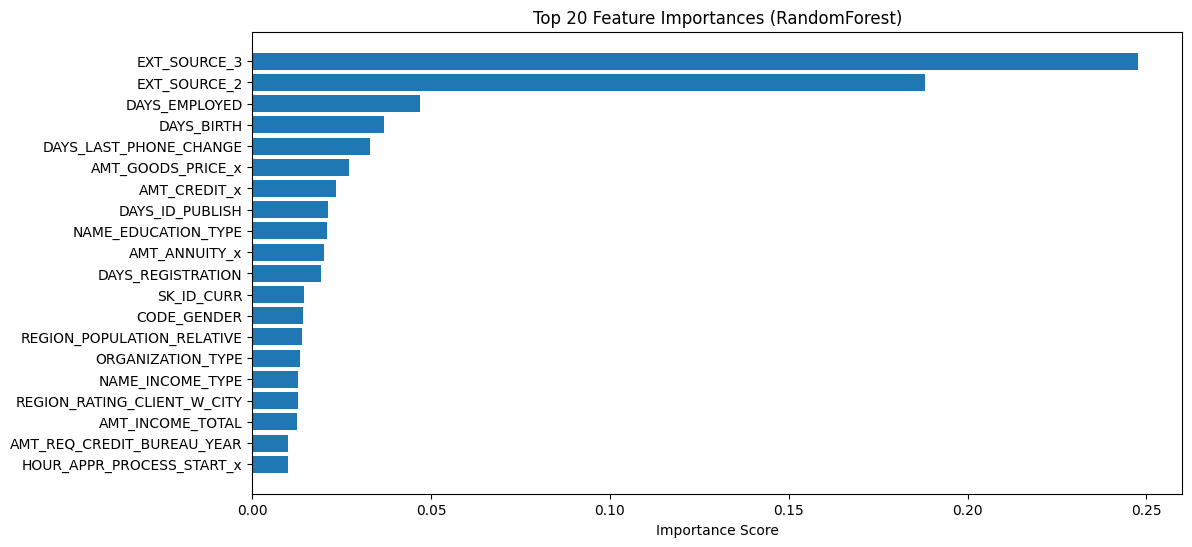

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top 20
print(feature_importance.head(20))

# Plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importance["Feature"].head(20), feature_importance["Importance"].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance Score")
plt.show()


In [29]:
drop = [
    'NAME_CONTRACT_TYPE_y','AMT_ANNUITY_y','AMT_CREDIT_y','AMT_GOODS_PRICE_y',
    'WEEKDAY_APPR_PROCESS_START_y','HOUR_APPR_PROCESS_START_y','DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
    'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
    'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',
    'SK_ID_PREV','FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY','NAME_SELLER_INDUSTRY',
    'NAME_YIELD_GROUP','PRODUCT_COMBINATION','SK_ID_CURR','SELLERPLACE_AREA','CHANNEL_TYPE',
    'NAME_PRODUCT_TYPE','NAME_PORTFOLIO','FLAG_EMP_PHONE','FLAG_MOBIL','CODE_REJECT_REASON',
    'NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY','NAME_HOUSING_TYPE','OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR','DAYS_DECISION','CNT_PAYMENT','DAYS_FIRST_DUE',
    'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION'
]

data.drop(columns=drop, inplace=True, errors="ignore")


In [30]:
data.shape

(1413701, 32)

In [31]:
EDA_data = (data.drop_duplicates())

In [32]:
EDA_data.shape

(1227086, 32)

In [33]:
EDA_data.head()

,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_APPLICATION,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,DAYS_FIRST_DRAWING,NFLAG_INSURED_ON_APPROVAL
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,Business Entity Type 3,0.262949,0.139376,-1134.0,179055.0,XAP,Approved,XNA,365243.0,0.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,School,0.622246,0.510090,-828.0,900000.0,XNA,Approved,XNA,365243.0,1.0
2,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,School,0.622246,0.510090,-828.0,337500.0,XAP,Approved,Cash through the bank,365243.0,0.0
3,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,School,0.622246,0.510090,-828.0,68809.5,XAP,Approved,Cash through the bank,365243.0,1.0
4,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,Government,0.555912,0.729567,-815.0,24282.0,XAP,Approved,Cash through the bank,365243.0,0.0


In [34]:
EDA_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1227086 entries, 0 to 1413700
Data columns (total 32 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   TARGET                        1227086 non-null  int64  
 1   NAME_CONTRACT_TYPE_x          1227086 non-null  object 
 2   CODE_GENDER                   1227086 non-null  object 
 3   FLAG_OWN_CAR                  1227086 non-null  object 
 4   FLAG_OWN_REALTY               1227086 non-null  object 
 5   CNT_CHILDREN                  1227086 non-null  int64  
 6   AMT_INCOME_TOTAL              1227086 non-null  float64
 7   AMT_CREDIT_x                  1227086 non-null  float64
 8   AMT_ANNUITY_x                 1227086 non-null  float64
 9   AMT_GOODS_PRICE_x             1227086 non-null  float64
 10  NAME_TYPE_SUITE_x             1227086 non-null  object 
 11  NAME_INCOME_TYPE              1227086 non-null  object 
 12  NAME_EDUCATION_TYPE           122

In [35]:
import numpy as np

APPLICATION_YEAR = 2018

EDA_data["DAYS_EMPLOYED"] = EDA_data["DAYS_EMPLOYED"].replace(365243, np.nan)

EDA_data["AGE_YEARS"] = (-EDA_data["DAYS_BIRTH"] / 365.25).round(0)
EDA_data["EMPLOYED_YEARS"] = (-EDA_data["DAYS_EMPLOYED"] / 365.25).round(0)

EDA_data["BIRTH_YEAR"] = (APPLICATION_YEAR - EDA_data["AGE_YEARS"]).astype("Int64")
EDA_data["EMPLOYMENT_START_YEAR"] = (
    APPLICATION_YEAR - EDA_data["EMPLOYED_YEARS"]
).astype("Int64")

EDA_data.drop(columns=["DAYS_BIRTH", "DAYS_EMPLOYED"], inplace=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\3630631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EDA_data["DAYS_EMPLOYED"] = EDA_data["DAYS_EMPLOYED"].replace(365243, np.nan)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\3630631.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EDA_data["AGE_YEARS"] = (-EDA_data["DAYS_BIRTH"] / 365.25).round(0)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\3630631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [36]:
EDA_data

,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,AMT_APPLICATION,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,DAYS_FIRST_DRAWING,NFLAG_INSURED_ON_APPROVAL,AGE_YEARS,EMPLOYED_YEARS,BIRTH_YEAR,EMPLOYMENT_START_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,179055.0,XAP,Approved,XNA,365243.0,0.0,26.0,2.0,1992,2016
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,900000.0,XNA,Approved,XNA,365243.0,1.0,46.0,3.0,1972,2015
2,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,337500.0,XAP,Approved,Cash through the bank,365243.0,0.0,46.0,3.0,1972,2015
3,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,68809.5,XAP,Approved,Cash through the bank,365243.0,1.0,46.0,3.0,1972,2015
4,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,24282.0,XAP,Approved,Cash through the bank,365243.0,0.0,52.0,1.0,1966,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413696,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,229500.0,XNA,Approved,Cash through the bank,365243.0,1.0,46.0,3.0,1972,2015
1413697,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,45000.0,XAP,Refused,XNA,365243.0,0.0,46.0,3.0,1972,2015
1413698,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,765000.0,Repairs,Refused,Cash through the bank,365243.0,0.0,46.0,3.0,1972,2015
1413699,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,1170000.0,XNA,Approved,Cash through the bank,365243.0,0.0,46.0,3.0,1972,2015


In [37]:
EDA_data.to_csv('eda_data.csv',index=False)

In [38]:
EDA_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1227086 entries, 0 to 1413700
Data columns (total 34 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   TARGET                        1227086 non-null  int64  
 1   NAME_CONTRACT_TYPE_x          1227086 non-null  object 
 2   CODE_GENDER                   1227086 non-null  object 
 3   FLAG_OWN_CAR                  1227086 non-null  object 
 4   FLAG_OWN_REALTY               1227086 non-null  object 
 5   CNT_CHILDREN                  1227086 non-null  int64  
 6   AMT_INCOME_TOTAL              1227086 non-null  float64
 7   AMT_CREDIT_x                  1227086 non-null  float64
 8   AMT_ANNUITY_x                 1227086 non-null  float64
 9   AMT_GOODS_PRICE_x             1227086 non-null  float64
 10  NAME_TYPE_SUITE_x             1227086 non-null  object 
 11  NAME_INCOME_TYPE              1227086 non-null  object 
 12  NAME_EDUCATION_TYPE           122

In [41]:
eda=pd.read_csv("eda_data.csv")

In [42]:
eda

,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,AMT_APPLICATION,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,DAYS_FIRST_DRAWING,NFLAG_INSURED_ON_APPROVAL,AGE_YEARS,EMPLOYED_YEARS,BIRTH_YEAR,EMPLOYMENT_START_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,179055.0,XAP,Approved,XNA,365243.0,0.0,26.0,2.0,1992,2016
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,900000.0,XNA,Approved,XNA,365243.0,1.0,46.0,3.0,1972,2015
2,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,337500.0,XAP,Approved,Cash through the bank,365243.0,0.0,46.0,3.0,1972,2015
3,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,68809.5,XAP,Approved,Cash through the bank,365243.0,1.0,46.0,3.0,1972,2015
4,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,24282.0,XAP,Approved,Cash through the bank,365243.0,0.0,52.0,1.0,1966,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227081,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,229500.0,XNA,Approved,Cash through the bank,365243.0,1.0,46.0,3.0,1972,2015
1227082,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,45000.0,XAP,Refused,XNA,365243.0,0.0,46.0,3.0,1972,2015
1227083,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,765000.0,Repairs,Refused,Cash through the bank,365243.0,0.0,46.0,3.0,1972,2015
1227084,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,1170000.0,XNA,Approved,Cash through the bank,365243.0,0.0,46.0,3.0,1972,2015


In [43]:
def plot(eda, col, title, pie_colors):
    bar_color = '#7B68EE'  # Purple for bars

    # Calculate value counts
    value_counts = eda[col].value_counts()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ---- Pie Chart ----
    explode = [0.1 if i == 0 else 0 for i in range(len(value_counts))]  # only explode the largest
    value_counts.plot.pie(
        ax=axes[0],
        autopct="%1.0f%%",
        colors=pie_colors[:len(value_counts)],
        startangle=60,
        wedgeprops={"linewidth": 1, "edgecolor": "k"},
        explode=explode,
        shadow=True
    )
    axes[0].set_title(f"Distribution of {title}")

    # ---- Bar Chart ----
    ax = value_counts.plot(kind="barh", color=bar_color, ax=axes[1])
    for i, (value, label) in enumerate(zip(value_counts.values, value_counts.index)):
        ax.text(value, i, f' {value}', weight="bold", fontsize=11, color='black')
    axes[1].set_title(f"Count of {title}")

    # Layout
    plt.tight_layout()
    plt.show()


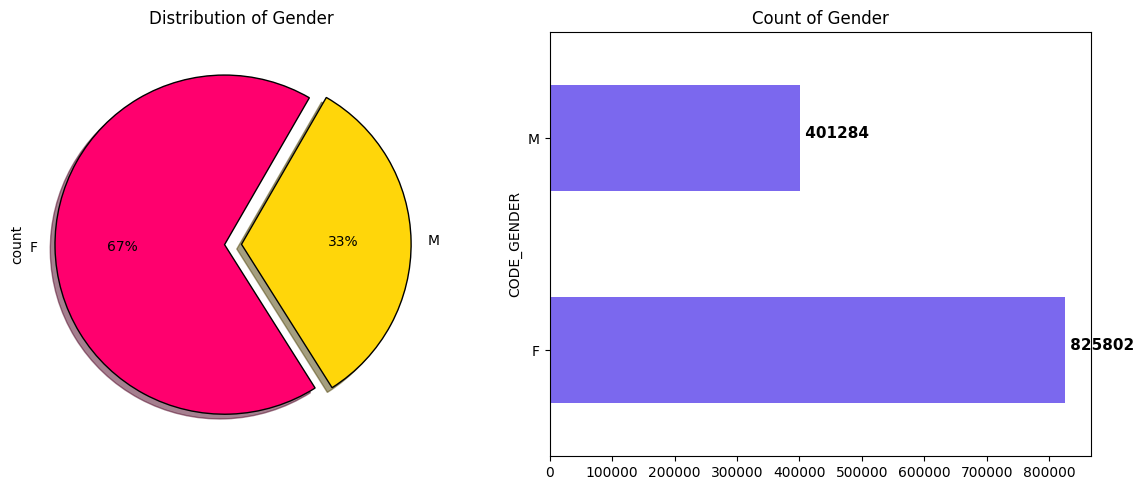

In [44]:
pie_colors = ["#ff006e", "#ffd60a", "#6a0dad", "#ff4500"]
plot(eda, "CODE_GENDER", "Gender", pie_colors)


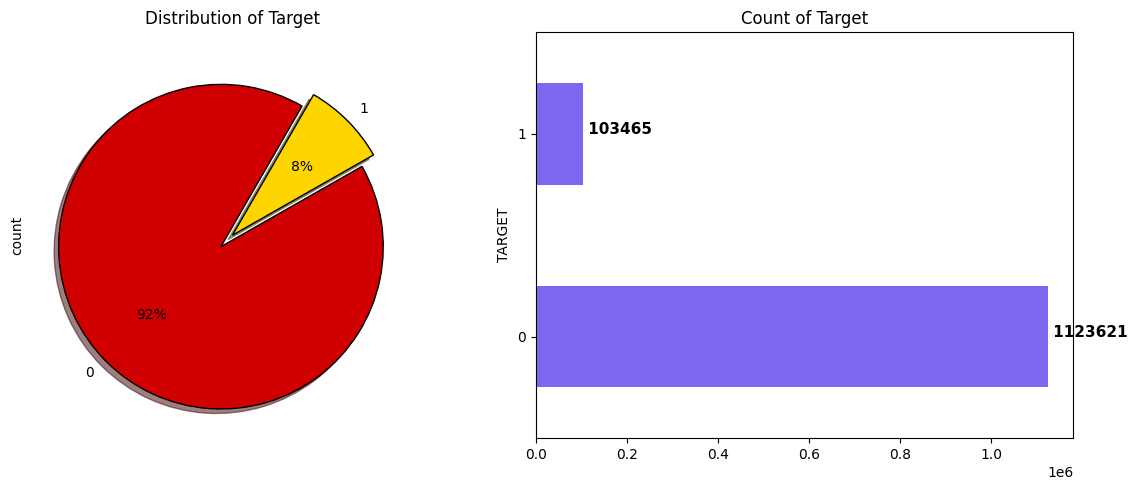

In [45]:
pie_colors = ['#d00000', '#ffd500','#f72585', '#ff4500']
plot(eda, "TARGET", "Target", pie_colors)

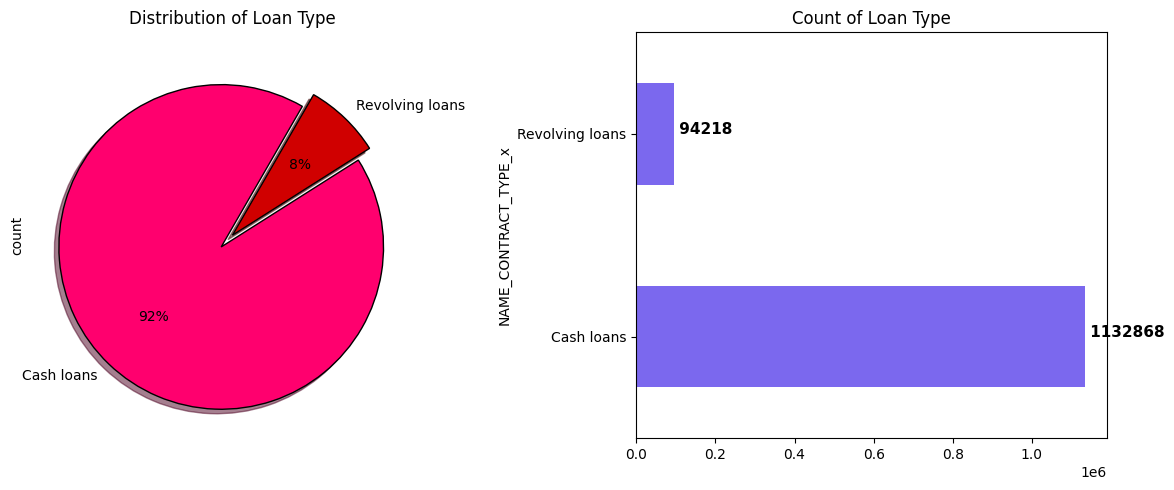

In [46]:
pie_colors = ['#ff006e', '#d00000','#f72585', '#ff4500']
plot(eda, "NAME_CONTRACT_TYPE_x", "Loan Type", pie_colors)


C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\3338467757.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(x="NAME_CONTRACT_TYPE_x", hue="CODE_GENDER", data=eda, palette=["#00bbf9", "#f15bb5", "#ee964b"], ax=ax)


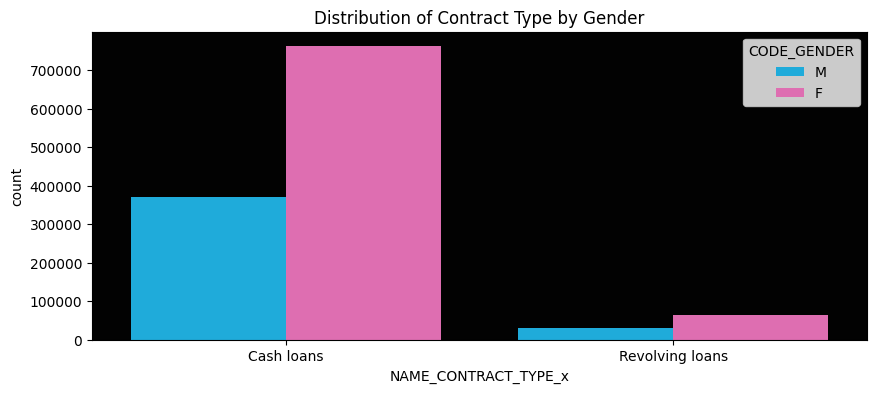

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x="NAME_CONTRACT_TYPE_x", hue="CODE_GENDER", data=eda, palette=["#00bbf9", "#f15bb5", "#ee964b"], ax=ax)
ax.set_facecolor("#020202")
ax.set_title("Distribution of Contract Type by Gender")
plt.show()

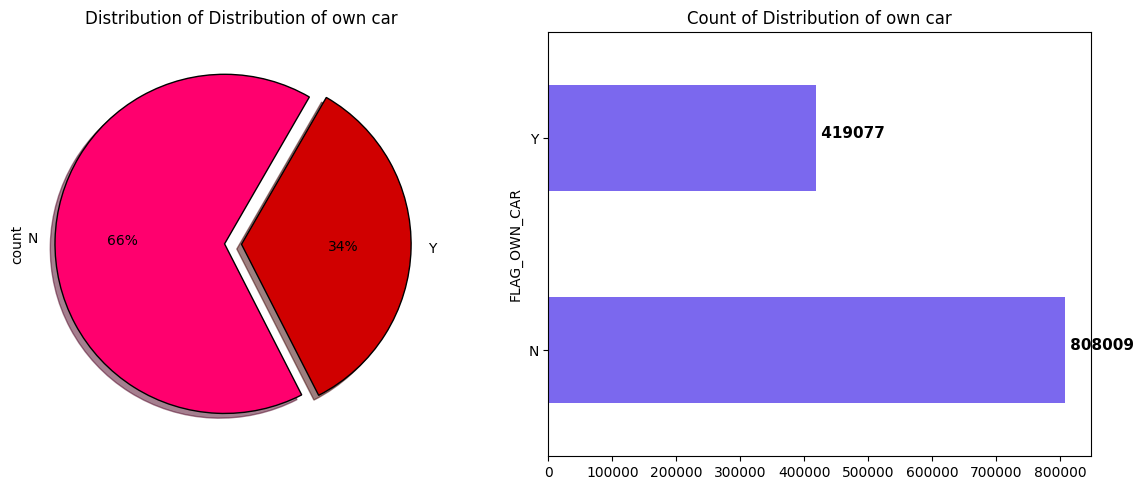

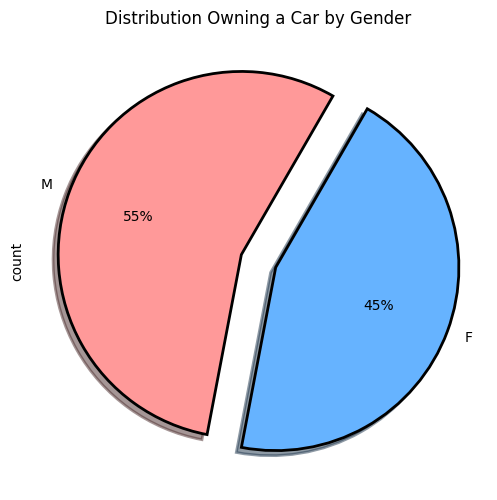

In [49]:
pie_colors = ['#ff006e', '#d00000','#f72585', '#ff4500']
plot(eda, "FLAG_OWN_CAR", "Distribution of own car", pie_colors)

fig = plt.figure(figsize=(13, 6))
ax = plt.subplot(121)

value_counts = eda[eda["FLAG_OWN_CAR"] == "Y"]["CODE_GENDER"].value_counts()
pie_colors = ['#ff9999', '#66b3ff', '#99ff99']
value_counts.plot.pie(
    autopct="%1.0f%%",
    colors=pie_colors[:len(value_counts)],
    startangle=60,
    wedgeprops={"linewidth": 2, "edgecolor": "k"},
    explode=[0.1] * len(value_counts),
    shadow=True,
    ax=ax
)
ax.set_title("Distribution Owning a Car by Gender")
plt.show()

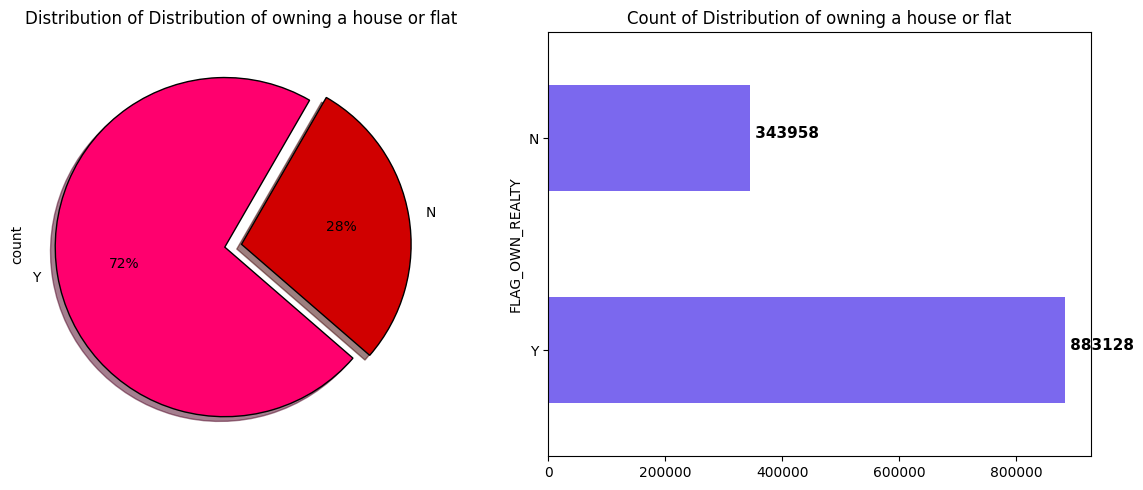

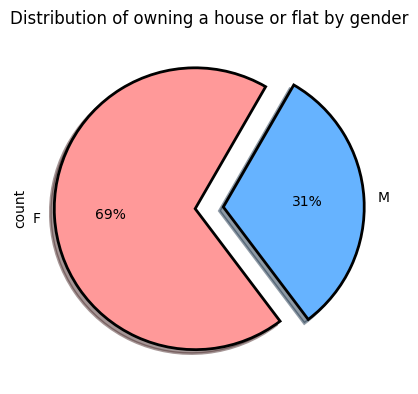

In [50]:

pie_colors = ['#ff006e', '#d00000','#f72585', '#ff4500']
plot(eda, "FLAG_OWN_REALTY", "Distribution of owning a house or flat", pie_colors)

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(121)
value_counts = eda[eda["FLAG_OWN_REALTY"] == "Y"]["CODE_GENDER"].value_counts()
pie_colors = ['#ff9999', '#66b3ff', '#99ff99']
value_counts.plot.pie(
    autopct="%1.0f%%",
    colors=pie_colors[:len(value_counts)],
    startangle=60,
    wedgeprops={"linewidth": 2, "edgecolor": "k"},
    explode=[0.1] * len(value_counts),
    shadow=True,
    ax=ax
)
ax.set_title("Distribution of owning a house or flat by gender")
plt.show()

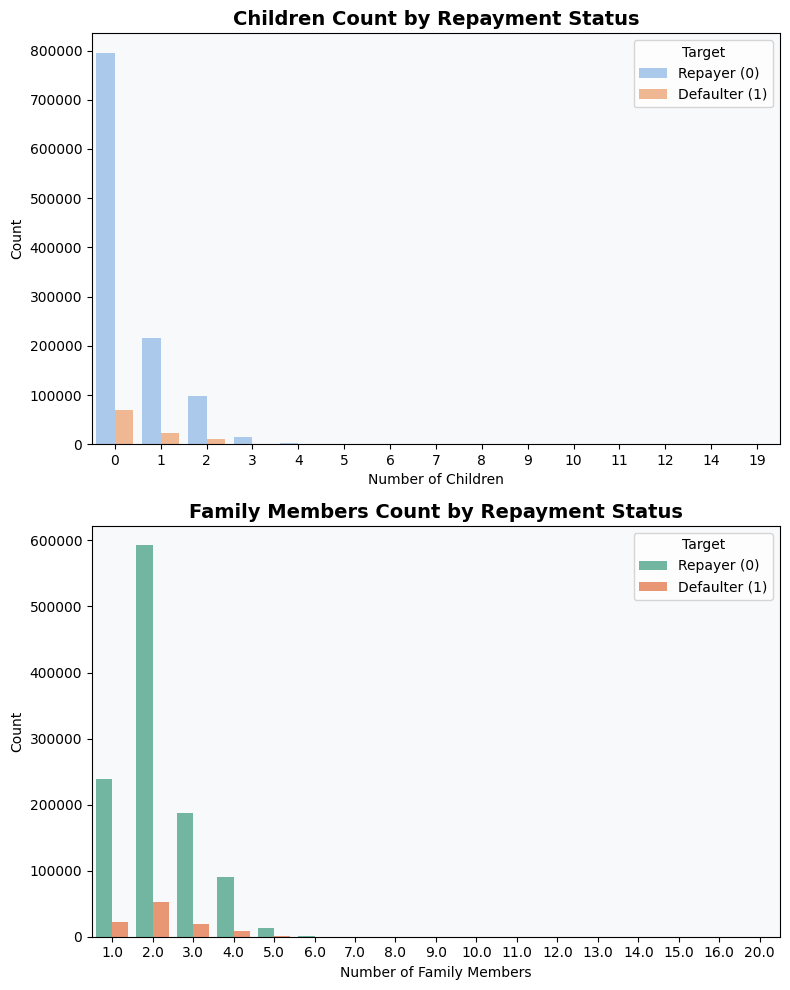

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# --- Children Count ---
sns.countplot(x="CNT_CHILDREN", hue="TARGET", data=eda, palette="pastel", ax=axes[0])
axes[0].set_title("Children Count by Repayment Status", fontsize=14, weight="bold")
axes[0].set_xlabel("Number of Children")
axes[0].set_ylabel("Count")
axes[0].set_facecolor("#f8f9fa")  # light grey background
axes[0].legend(title="Target", labels=["Repayer (0)", "Defaulter (1)"], loc="upper right")

# --- Family Members Count ---
sns.countplot(x="CNT_FAM_MEMBERS", hue="TARGET", data=eda, palette="Set2", ax=axes[1])
axes[1].set_title("Family Members Count by Repayment Status", fontsize=14, weight="bold")
axes[1].set_xlabel("Number of Family Members")
axes[1].set_ylabel("Count")
axes[1].set_facecolor("#f8f9fa")
axes[1].legend(title="Target", labels=["Repayer (0)", "Defaulter (1)"], loc="upper right")

# Layout
plt.tight_layout()
plt.show()


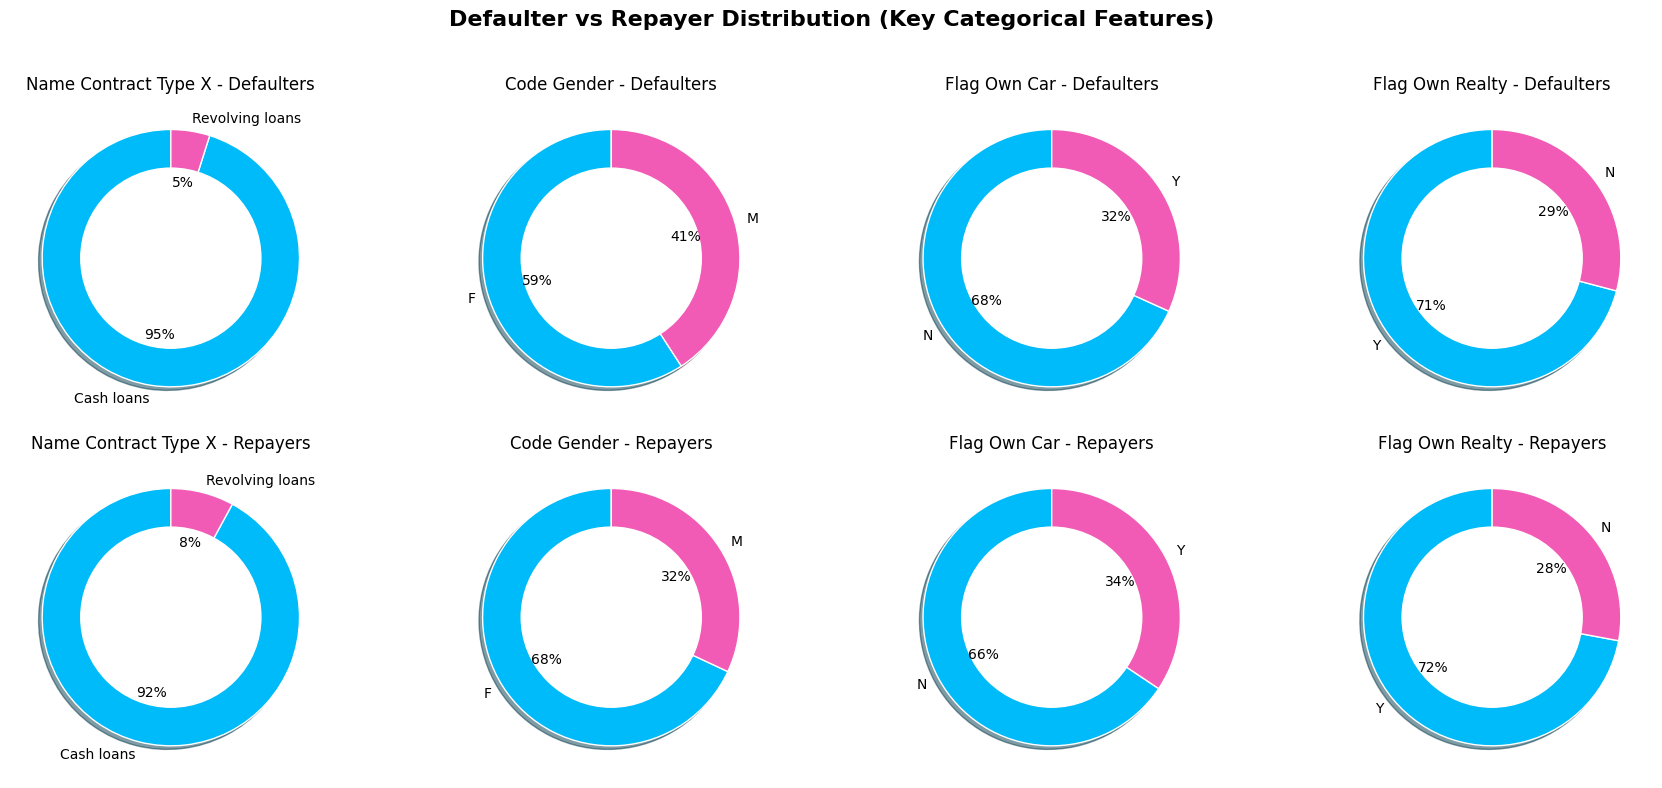

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to analyze
d_cols = ['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

# Create subplots: 2 rows (Defaulter & Repayer), 4 cols (variables)
fig, axes = plt.subplots(2, len(d_cols), figsize=(18, 8))

# Color palette (consistent across all pies)
pie_colors = ["#00bbf9", "#f15bb5", "#ffb703", "#9b5de5"]

# Loop through columns
for j, col in enumerate(d_cols):
    # --- Defaulter ---
    ax = axes[0, j]
    eda[eda["TARGET"]==1][col].value_counts().plot.pie(
        autopct="%1.0f%%",
        colors=pie_colors[:eda[col].nunique()],
        startangle=90,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        shadow=True,
        ax=ax
    )
    ax.add_artist(plt.Circle((0,0),0.7,color="white"))  # donut
    ax.set_ylabel("")
    ax.set_title(f"{col.replace('_',' ').title()} - Defaulters")

    # --- Repayer ---
    ax = axes[1, j]
    eda[eda["TARGET"]==0][col].value_counts().plot.pie(
        autopct="%1.0f%%",
        colors=pie_colors[:eda[col].nunique()],
        startangle=90,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        shadow=True,
        ax=ax
    )
    ax.add_artist(plt.Circle((0,0),0.7,color="white"))
    ax.set_ylabel("")
    ax.set_title(f"{col.replace('_',' ').title()} - Repayers")

plt.suptitle("Defaulter vs Repayer Distribution (Key Categorical Features)", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


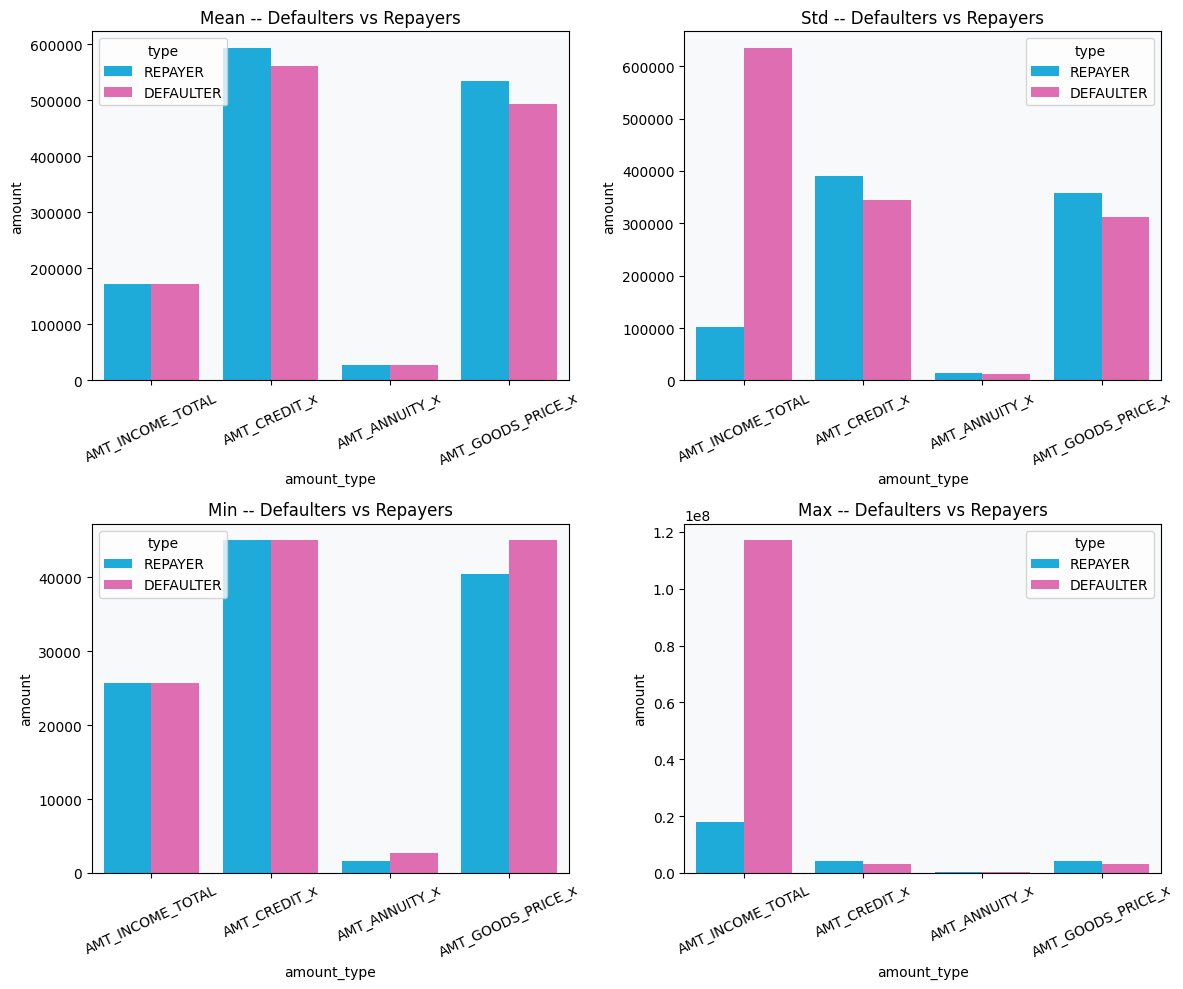

In [53]:
import itertools

cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT_x','AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x']

# Group by TARGET and get descriptive stats
df = eda.groupby("TARGET")[cols].describe().transpose().reset_index()
df = df[df["level_1"].isin(['mean', 'std', 'min', 'max'])]

# Safer extraction (use .loc instead of numeric column index)
df_x = df.loc[:, ["level_0", "level_1", 0]].rename(
    columns={'level_0': "amount_type", 'level_1': "statistic", 0: "amount"}
)
df_x["type"] = "REPAYER"

df_y = df.loc[:, ["level_0", "level_1", 1]].rename(
    columns={'level_0': "amount_type", 'level_1': "statistic", 1: "amount"}
)
df_y["type"] = "DEFAULTER"

# Combine
df_new = pd.concat([df_x, df_y], axis=0)

# Plot
stat = df_new["statistic"].unique().tolist()

plt.figure(figsize=(12, 10))

for j, i in enumerate(stat):
    plt.subplot(2, 2, j + 1)
    sns.barplot(
        x="amount_type",
        y="amount",
        hue="type",
        data=df_new[df_new["statistic"] == i],
        palette=["#00bbf9", "#f15bb5"]  # Blue = REPAYER, Pink = DEFAULTER
    )
    plt.title(f"{i.capitalize()} -- Defaulters vs Repayers")
    plt.xticks(rotation=25)
    plt.gca().set_facecolor("#f8f9fa")

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\3866352597.py:26: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(x="amt_type", y="amount", data=df_gen, hue="gender",


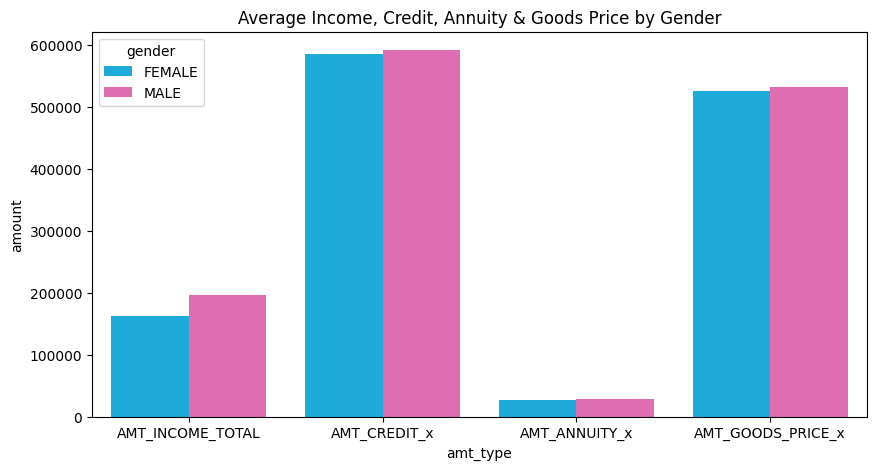

In [54]:
df1 = data.groupby("CODE_GENDER")[cols].mean().transpose().reset_index()

# Collect gender-specific DataFrames
df_list = []

if "F" in df1.columns:
    df_f = df1[["index", "F"]].rename(columns={'index': "amt_type", 'F': "amount"})
    df_f["gender"] = "FEMALE"
    df_list.append(df_f)

if "M" in df1.columns:
    df_m = df1[["index", "M"]].rename(columns={'index': "amt_type", 'M': "amount"})
    df_m["gender"] = "MALE"
    df_list.append(df_m)

if "XNA" in df1.columns:
    df_xna = df1[["index", "XNA"]].rename(columns={'index': "amt_type", 'XNA': "amount"})
    df_xna["gender"] = "XNA"
    df_list.append(df_xna)

# Merge all available genders
df_gen = pd.concat(df_list, axis=0)

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="amt_type", y="amount", data=df_gen, hue="gender",
                 palette=["#00bbf9", "#f15bb5", "#9b5de5"])  # custom colors
plt.title("Average Income, Credit, Annuity & Goods Price by Gender")
plt.xticks(rotation=0)
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\1458224952.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


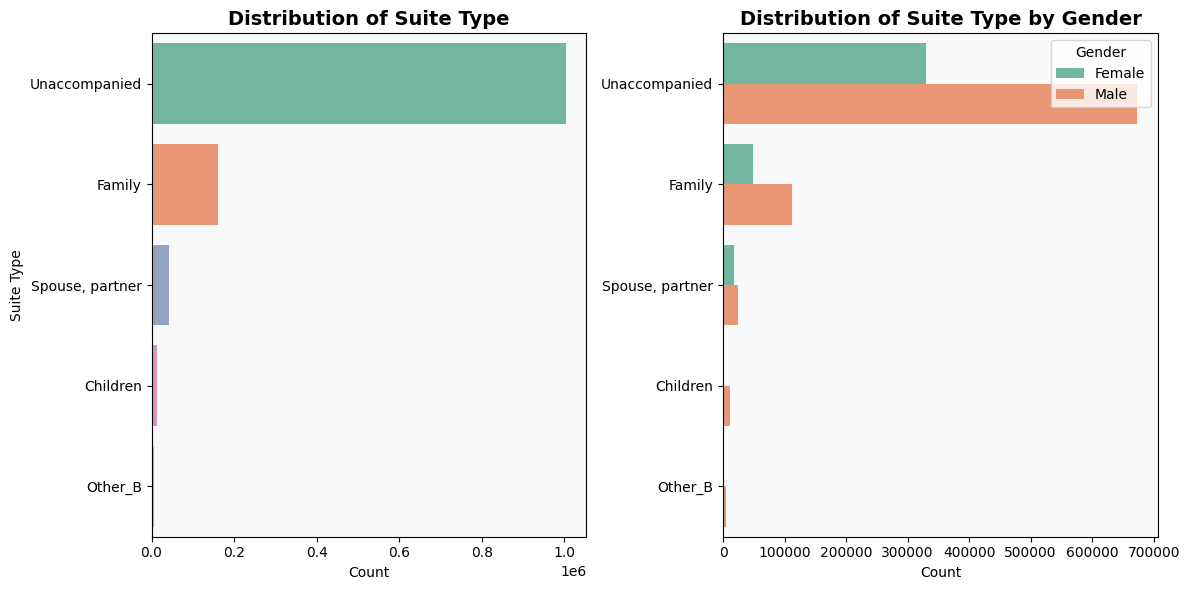

In [55]:
# Get top 5 Suite Types
top_suites = eda["NAME_TYPE_SUITE_x"].value_counts().index[:5]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot 1: Overall Distribution ---
sns.countplot(
    y="NAME_TYPE_SUITE_x",
    data=eda,
    order=top_suites,
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("Distribution of Suite Type", fontsize=14, weight="bold")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Suite Type")
axes[0].set_facecolor("#f8f9fa")

# --- Plot 2: Distribution by Gender ---
sns.countplot(
    y="NAME_TYPE_SUITE_x",
    hue="CODE_GENDER",
    data=eda,
    order=top_suites,
    palette="Set2",
    ax=axes[1]
)
axes[1].set_title("Distribution of Suite Type by Gender", fontsize=14, weight="bold")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
axes[1].set_facecolor("#f8f9fa")
axes[1].legend(title="Gender", labels=["Female", "Male"], loc="upper right")

# Layout
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\580161989.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


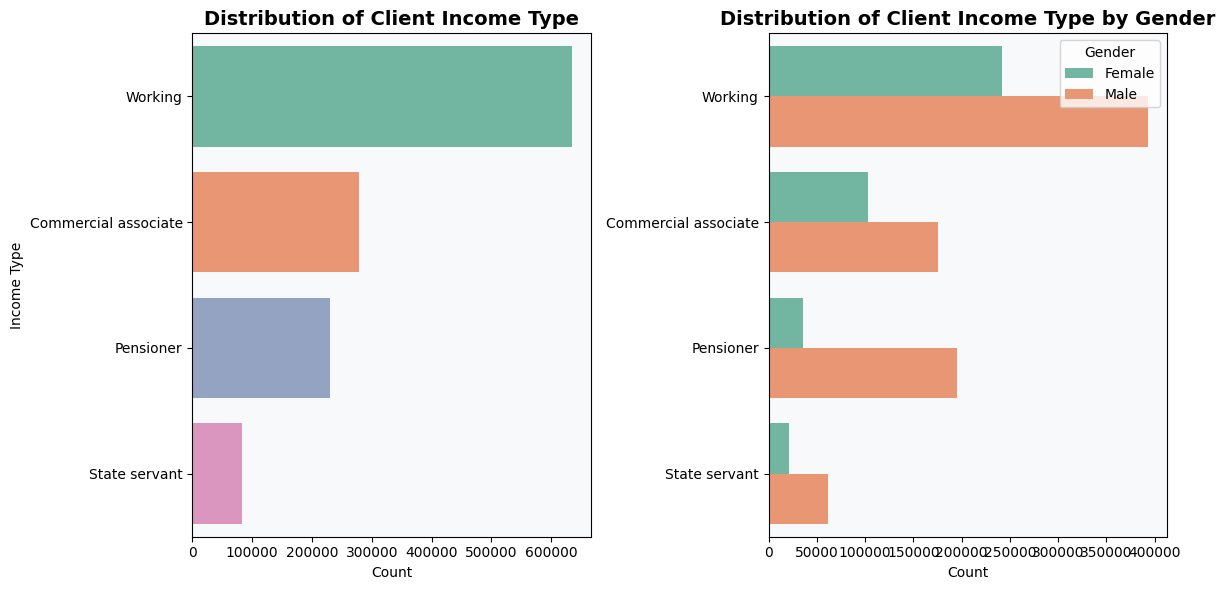

In [56]:
# Get top 4 Income Types
top_income_types = eda["NAME_INCOME_TYPE"].value_counts().index[:4]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot 1: Overall Distribution ---
sns.countplot(
    y="NAME_INCOME_TYPE",
    data=eda,
    order=top_income_types,
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("Distribution of Client Income Type", fontsize=14, weight="bold")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Income Type")
axes[0].set_facecolor("#f8f9fa")

# --- Plot 2: Distribution by Gender ---
sns.countplot(
    y="NAME_INCOME_TYPE",
    hue="CODE_GENDER",
    data=eda,
    order=top_income_types,
    palette="Set2",
    ax=axes[1]
)
axes[1].set_title("Distribution of Client Income Type by Gender", fontsize=14, weight="bold")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
axes[1].set_facecolor("#f8f9fa")
axes[1].legend(title="Gender", labels=["Female", "Male"], loc="upper right")

# Layout
plt.tight_layout()
plt.show()


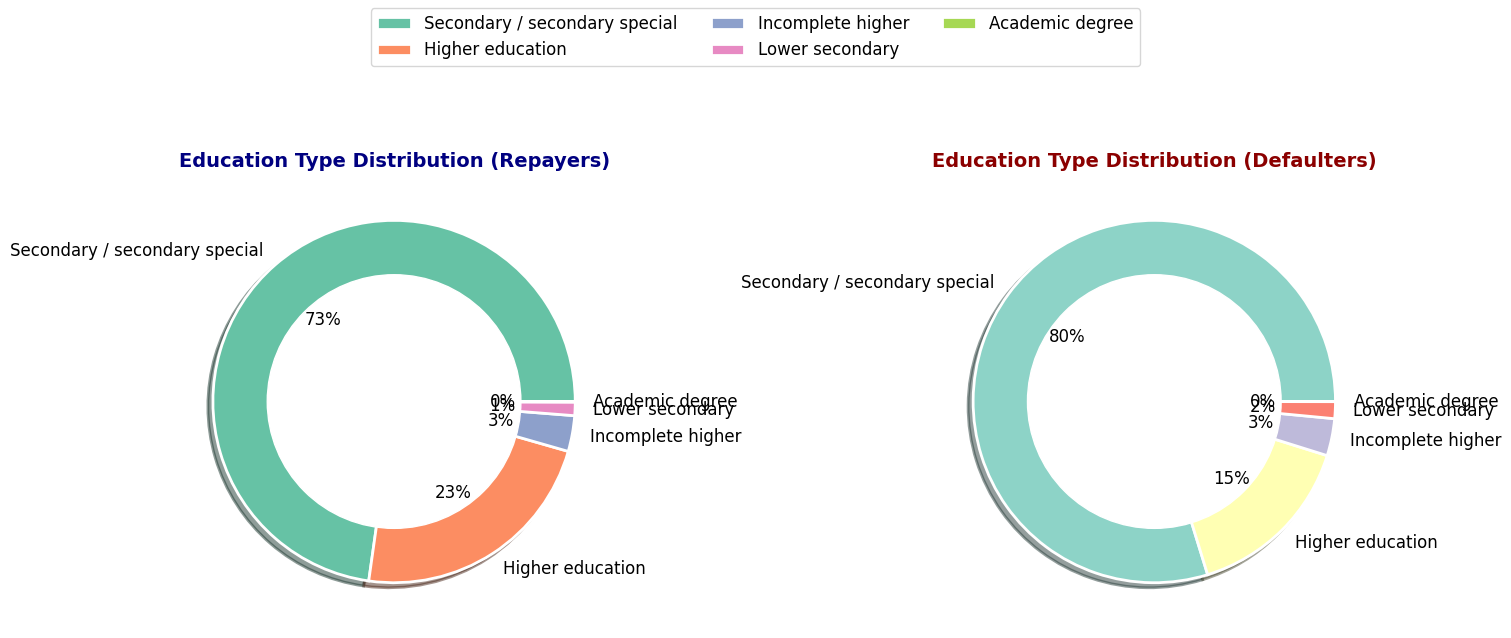

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Repayers
eda[eda["TARGET"] == 0]["NAME_EDUCATION_TYPE"].value_counts().plot.pie(
    ax=axes[0],
    fontsize=12,
    autopct="%1.0f%%",
    colors=sns.color_palette("Set2"),
    wedgeprops={"linewidth": 2, "edgecolor": "white"},
    shadow=True
)
axes[0].add_artist(plt.Circle((0, 0), .7, color="white"))
axes[0].set_title("Education Type Distribution (Repayers)", fontsize=14, weight="bold", color="navy")
axes[0].set_ylabel("")

# Defaulters
eda[eda["TARGET"] == 1]["NAME_EDUCATION_TYPE"].value_counts().plot.pie(
    ax=axes[1],
    fontsize=12,
    autopct="%1.0f%%",
    colors=sns.color_palette("Set3"),
    wedgeprops={"linewidth": 2, "edgecolor": "white"},
    shadow=True
)
axes[1].add_artist(plt.Circle((0, 0), .7, color="white"))
axes[1].set_title("Education Type Distribution (Defaulters)", fontsize=14, weight="bold", color="darkred")
axes[1].set_ylabel("")

# Add Legends (outside plots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=12)

plt.tight_layout()
plt.show()


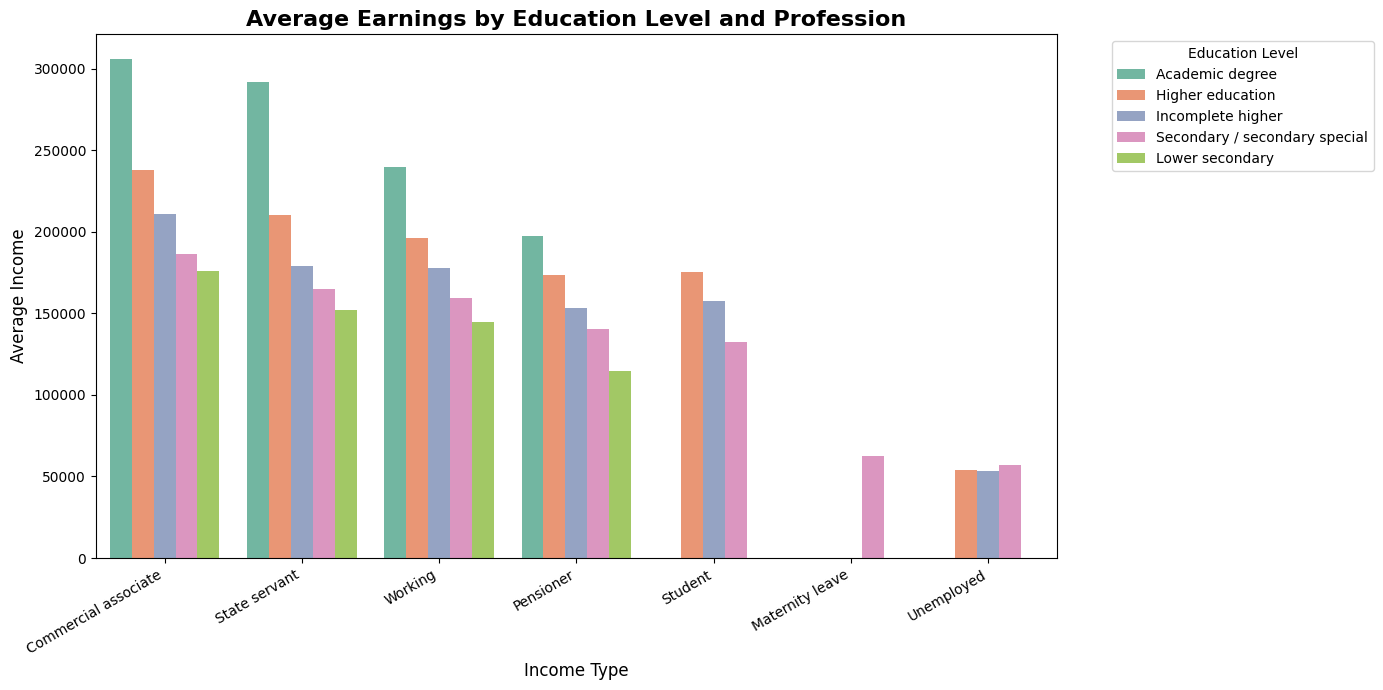

In [58]:
edu = (
    eda.groupby(['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE'])['AMT_INCOME_TOTAL']
    .mean()
    .reset_index()
    .sort_values(by='AMT_INCOME_TOTAL', ascending=False)
)

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x='NAME_INCOME_TYPE',
    y='AMT_INCOME_TOTAL',
    data=edu,
    hue='NAME_EDUCATION_TYPE',
    palette="Set2",
    order=edu.groupby("NAME_INCOME_TYPE")["AMT_INCOME_TOTAL"].mean().sort_values(ascending=False).index
)

plt.title("Average Earnings by Education Level and Profession", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Average Income", fontsize=12)
plt.xlabel("Income Type", fontsize=12)
plt.legend(title="Education Level", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\2300222613.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\2300222613.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


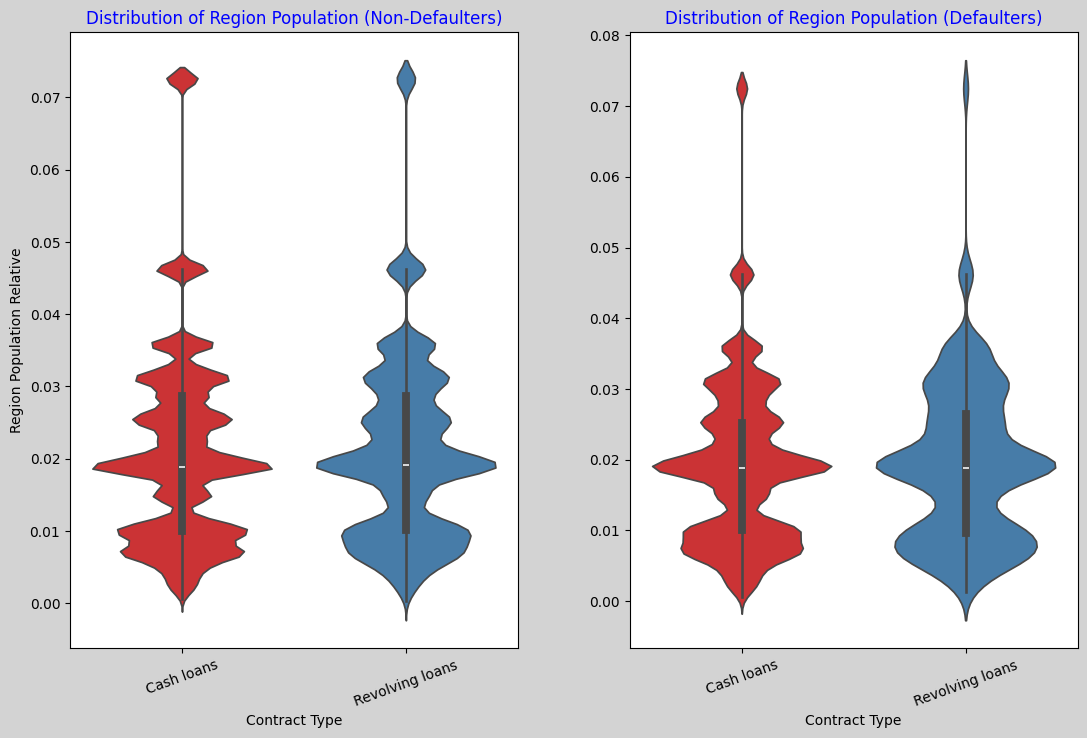

In [59]:
fig = plt.figure(figsize=(13, 8))

# Define consistent order for x-axis
order = eda["NAME_CONTRACT_TYPE_x"].value_counts().index

# Non-Defaulters
plt.subplot(121)
sns.violinplot(
    data=eda[eda["TARGET"]==0],
    x="NAME_CONTRACT_TYPE_x",
    y="REGION_POPULATION_RELATIVE",
    palette="Set1",
    order=order
)
plt.title("Distribution of Region Population (Non-Defaulters)", color="b")
plt.xlabel("Contract Type")
plt.ylabel("Region Population Relative")
plt.xticks(rotation=20)

# Defaulters
plt.subplot(122)
sns.violinplot(
    data=eda[eda["TARGET"]==1],
    x="NAME_CONTRACT_TYPE_x",
    y="REGION_POPULATION_RELATIVE",
    palette="Set1",
    order=order
)
plt.title("Distribution of Region Population (Defaulters)", color="b")
plt.xlabel("Contract Type")
plt.ylabel("")
plt.xticks(rotation=20)

# Layout & background
plt.subplots_adjust(wspace=.25)
fig.set_facecolor("lightgrey")

plt.show()


In [60]:

df_repayer = eda[eda['TARGET'] == 0]
df_defaulter = eda[eda['TARGET'] == 1]

In [61]:
# Compute correlations for numeric columns
corrmat = df_repayer.select_dtypes(include=[float, int]).corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool), k=1)

# Flatten to long format
corrdf = corrmat.where(mask).stack().reset_index()
corrdf.columns = ['Var1', 'Var2', 'Correlation']

# Drop NaN and round
corrdf.dropna(subset=['Correlation'], inplace=True)
corrdf['Correlation'] = corrdf['Correlation'].round(2)

# Top correlations (absolute values)
top_corr = corrdf.reindex(corrdf.Correlation.abs().sort_values(ascending=False).index).head(10)
print("🔝 Top 10 correlations:\n", top_corr)



🔝 Top 10 correlations:
                            Var1                   Var2  Correlation
166                   AGE_YEARS             BIRTH_YEAR        -1.00
169              EMPLOYED_YEARS  EMPLOYMENT_START_YEAR        -1.00
36                 AMT_CREDIT_x      AMT_GOODS_PRICE_x         0.99
5                  CNT_CHILDREN        CNT_FAM_MEMBERS         0.88
51                AMT_ANNUITY_x      AMT_GOODS_PRICE_x         0.77
35                 AMT_CREDIT_x          AMT_ANNUITY_x         0.76
81   REGION_POPULATION_RELATIVE   REGION_RATING_CLIENT        -0.52
19             AMT_INCOME_TOTAL          AMT_ANNUITY_x         0.41
14                 CNT_CHILDREN              AGE_YEARS        -0.37
16                 CNT_CHILDREN             BIRTH_YEAR         0.37


                        Variable         Chi2        p-value  DoF  \
10             ORGANIZATION_TYPE  7479.432253   0.000000e+00   57   
5               NAME_INCOME_TYPE  6285.832132   0.000000e+00    6   
8                OCCUPATION_TYPE  5035.318378   0.000000e+00   17   
11          NAME_CONTRACT_STATUS  4832.736865   0.000000e+00    3   
1                    CODE_GENDER  3951.850436   0.000000e+00    1   
6            NAME_EDUCATION_TYPE  3552.985891   0.000000e+00    4   
7             NAME_FAMILY_STATUS  1880.888416   0.000000e+00    4   
0           NAME_CONTRACT_TYPE_x  1478.289004   0.000000e+00    1   
12             NAME_PAYMENT_TYPE   981.895734  1.522176e-212    3   
2                   FLAG_OWN_CAR   297.566506   1.116747e-66    1   
9   WEEKDAY_APPR_PROCESS_START_x   238.345316   1.266437e-48    6   
4              NAME_TYPE_SUITE_x   103.260323   5.234823e-20    6   
3                FLAG_OWN_REALTY    77.576672   1.276691e-18    1   

    Min Expected  Significant  
1

C:\Users\DELL\AppData\Local\Temp\ipykernel_19592\1305841022.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Chi2", y="Variable", data=chi2_results_sorted, palette="viridis")


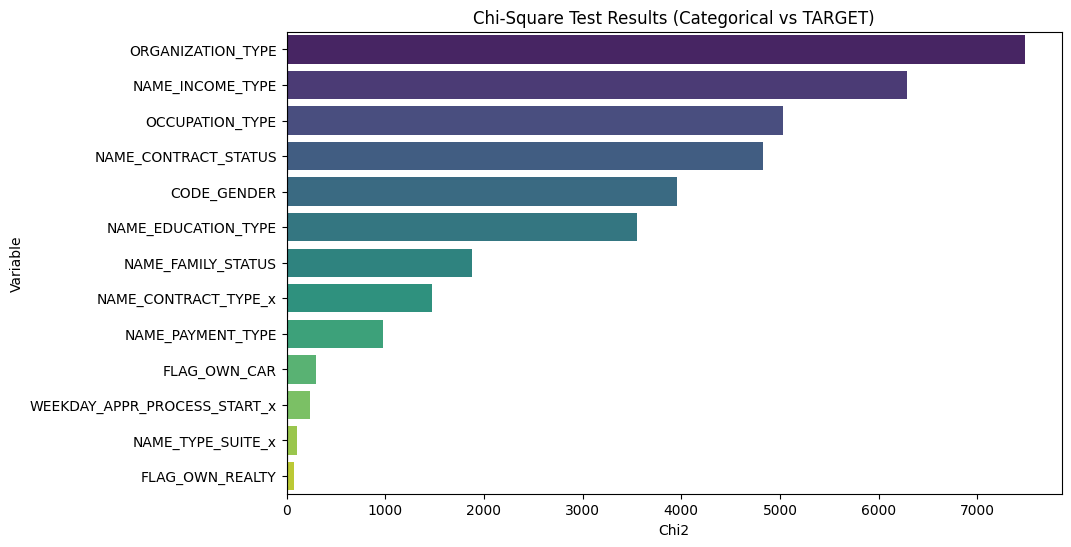

In [62]:

from scipy.stats import chi2_contingency

categorical_vars = [
    'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x',
    'ORGANIZATION_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE'
]

results = []
for col in categorical_vars:
    contingency_table = pd.crosstab(data[col], data['TARGET'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Variable': col,
        'Chi2': chi2,
        'p-value': p_value,
        'DoF': dof,
        'Min Expected': expected.min(),
        'Significant': p_value < 0.05
    })

chi2_results = pd.DataFrame(results)
chi2_results_sorted = chi2_results.sort_values(by=['Chi2'], ascending=False)

print(chi2_results_sorted)

# --- Visualization ---
plt.figure(figsize=(10,6))
sns.barplot(x="Chi2", y="Variable", data=chi2_results_sorted, palette="viridis")
plt.axvline(x=0, color="k", linestyle="--")
plt.title("Chi-Square Test Results (Categorical vs TARGET)")
plt.show()


In [63]:
Filtered_features = [
    'AMT_CREDIT_x', 'AMT_GOODS_PRICE_x', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'AMT_ANNUITY_x', 'AGE_YEARS', 'EMPLOYED_YEARS', 'REGION_POPULATION_RELATIVE',
    'REGION_RATING_CLIENT', 'AMT_INCOME_TOTAL', 'EXT_SOURCE_2','EXT_SOURCE_3',
    'HOUR_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE', 'NAME_CONTRACT_STATUS', 'CODE_GENDER',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_CONTRACT_TYPE_x',
    'TARGET'
]	

# Select only required features
data_clean = eda[Filtered_features]


# Save to CSV
data_clean.to_csv('cleaned_data.csv', index=False)
print(" Cleaned data saved as cleaned_data.csv")


 Cleaned data saved as cleaned_data.csv


In [64]:
df=pd.read_csv('cleaned_data.csv')

In [65]:
df

,AMT_CREDIT_x,AMT_GOODS_PRICE_x,CNT_CHILDREN,CNT_FAM_MEMBERS,AMT_ANNUITY_x,AGE_YEARS,EMPLOYED_YEARS,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,AMT_INCOME_TOTAL,...,HOUR_APPR_PROCESS_START_x,ORGANIZATION_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,NAME_CONTRACT_STATUS,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_CONTRACT_TYPE_x,TARGET
0,406597.5,351000.0,0,1.0,24700.5,26.0,2.0,0.018801,2,202500.0,...,10,Business Entity Type 3,Working,Laborers,Approved,M,Secondary / secondary special,Single / not married,Cash loans,1
1,1293502.5,1129500.0,0,2.0,35698.5,46.0,3.0,0.003541,1,270000.0,...,11,School,State servant,Core staff,Approved,F,Higher education,Married,Cash loans,0
2,1293502.5,1129500.0,0,2.0,35698.5,46.0,3.0,0.003541,1,270000.0,...,11,School,State servant,Core staff,Approved,F,Higher education,Married,Cash loans,0
3,1293502.5,1129500.0,0,2.0,35698.5,46.0,3.0,0.003541,1,270000.0,...,11,School,State servant,Core staff,Approved,F,Higher education,Married,Cash loans,0
4,135000.0,135000.0,0,1.0,6750.0,52.0,1.0,0.010032,2,67500.0,...,9,Government,Working,Laborers,Approved,M,Secondary / secondary special,Single / not married,Revolving loans,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227081,675000.0,675000.0,0,2.0,49117.5,46.0,3.0,0.046220,1,157500.0,...,20,Business Entity Type 3,Commercial associate,Laborers,Approved,F,Higher education,Married,Cash loans,0
1227082,675000.0,675000.0,0,2.0,49117.5,46.0,3.0,0.046220,1,157500.0,...,20,Business Entity Type 3,Commercial associate,Laborers,Refused,F,Higher education,Married,Cash loans,0
1227083,675000.0,675000.0,0,2.0,49117.5,46.0,3.0,0.046220,1,157500.0,...,20,Business Entity Type 3,Commercial associate,Laborers,Refused,F,Higher education,Married,Cash loans,0
1227084,675000.0,675000.0,0,2.0,49117.5,46.0,3.0,0.046220,1,157500.0,...,20,Business Entity Type 3,Commercial associate,Laborers,Approved,F,Higher education,Married,Cash loans,0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227086 entries, 0 to 1227085
Data columns (total 22 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   AMT_CREDIT_x                1227086 non-null  float64
 1   AMT_GOODS_PRICE_x           1227086 non-null  float64
 2   CNT_CHILDREN                1227086 non-null  int64  
 3   CNT_FAM_MEMBERS             1227086 non-null  float64
 4   AMT_ANNUITY_x               1227086 non-null  float64
 5   AGE_YEARS                   1227086 non-null  float64
 6   EMPLOYED_YEARS              1227086 non-null  float64
 7   REGION_POPULATION_RELATIVE  1227086 non-null  float64
 8   REGION_RATING_CLIENT        1227086 non-null  int64  
 9   AMT_INCOME_TOTAL            1227086 non-null  float64
 10  EXT_SOURCE_2                1227086 non-null  float64
 11  EXT_SOURCE_3                1227086 non-null  float64
 12  HOUR_APPR_PROCESS_START_x   1227086 non-null  int64  
 1

In [68]:
categorical_vars = [
    'ORGANIZATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE',
    'NAME_CONTRACT_STATUS','CODE_GENDER','NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS','NAME_CONTRACT_TYPE_x'
]


In [72]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le = LabelEncoder()
for col in categorical_vars:
    df.loc[:, col] = le.fit_transform(df[col].astype(str))

# Correlation with target
corrmat = df[categorical_vars + ['TARGET']].corr()

target_corr = (
    corrmat['TARGET']
    .drop('TARGET')
    .abs()
    .sort_values(ascending=False)
    .reset_index()
)
target_corr.columns = ['Variable', 'Correlation']

print("Top correlated categorical features with TARGET:")
print(target_corr.head(15))

# Show sample data
print("\nSample data after encoding:")
print(df.head(5))

# Full correlation matrix
correlation_matrix = df.corr()


Top correlated categorical features with TARGET:
               Variable  Correlation
0           CODE_GENDER     0.052632
1  NAME_CONTRACT_STATUS     0.048998
2   NAME_EDUCATION_TYPE     0.047889
3      NAME_INCOME_TYPE     0.045311
4  NAME_CONTRACT_TYPE_x     0.031827
5       OCCUPATION_TYPE     0.008742
6    NAME_FAMILY_STATUS     0.006974
7     ORGANIZATION_TYPE     0.003519

Sample data after encoding:
   AMT_CREDIT_x  AMT_GOODS_PRICE_x  CNT_CHILDREN  CNT_FAM_MEMBERS  \
0      406597.5           351000.0             0              1.0   
1     1293502.5          1129500.0             0              2.0   
2     1293502.5          1129500.0             0              2.0   
3     1293502.5          1129500.0             0              2.0   
4      135000.0           135000.0             0              1.0   

   AMT_ANNUITY_x  AGE_YEARS  EMPLOYED_YEARS  REGION_POPULATION_RELATIVE  \
0        24700.5       26.0             2.0                    0.018801   
1        35698.5       4

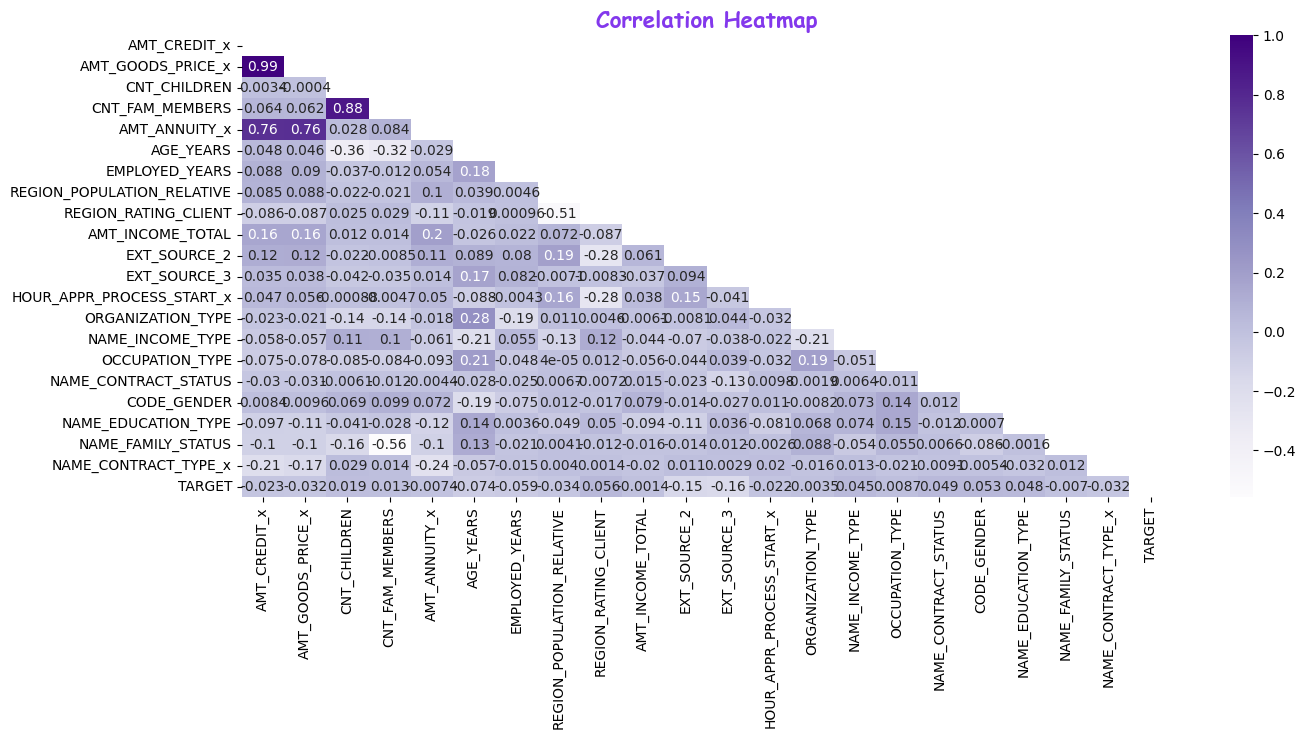

In [73]:
# correlation_matrix was already created earlier:
# correlation_matrix = data1.corr()

corr_matrix = correlation_matrix   # no need for .corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 6))

sns.heatmap(
    corr_matrix, 
    cmap="Purples", 
    annot=True, 
    mask=mask, 
    ax=ax, 
    vmax=1
)

ax.set_title(
    "Correlation Heatmap", 
    fontsize=16, 
    fontweight='bold', 
    fontname='Comic Sans MS', 
    color='#8338ec'
)
ax.tick_params(axis='both', colors='black')

plt.show()
